In [78]:
 #now, get 3k samples, one thousand for each dataset. Then, 
    #how to select sample

In [105]:
ls ./data

360dataset_rev/              saliency_ds2_topic6_part1
360dataset_v2.zip            saliency_ds2_topic6_part2
bk/                          saliency_ds2_topic6_part3
head-orientation/            saliency_ds2_topic7
README.md                    saliency_ds2_topic8
saleval_bk                   saliency_ds3_topiccoaster_
saliency_ds1_topicdiving     saliency_ds3_topiccoaster2_
saliency_ds1_topicparis      saliency_ds3_topicdiving
saliency_ds1_topicroller     saliency_ds3_topicdrive
saliency_ds1_topictimelapse  saliency_ds3_topicgame
saliency_ds1_topicvenise     saliency_ds3_topiclandscape
saliency_ds2_topic0          saliency_ds3_topicpacman
saliency_ds2_topic1          saliency_ds3_topicpanel
saliency_ds2_topic2          saliency_ds3_topicride
saliency_ds2_topic3          saliency_ds3_topicsport
saliency_ds2_topic4          saliency_evaldat
saliency_ds2_topic5_part1    viz_filtered_fixation
saliency_ds2_topic5_part2


In [106]:
import pickle
import numpy as np
import head_orientation_lib
import saldat_head_orientation
import saldat_eval
import saldat_saliency
from sklearn import metrics

reload(head_orientation_lib)
reload(saldat_eval)

from matplotlib import pyplot as plt
%matplotlib inline

In [107]:
dirpath1 = u'./data/head-orientation/dataset1'
dirpath2 = u'./data/head-orientation/dataset2/Experiment_1'
dirpath3 = u'./data/head-orientation/dataset3/sensory/orientation'
ext1 = '.txt'
ext2 = '.csv'
ext3 = '.csv'
headoren = saldat_head_orientation.HeadOrientation(dirpath1, dirpath2, dirpath3, ext1, ext2, ext3)

var = 20
salsal = saldat_saliency.Fixation(var)

saleval = saldat_eval.SalEvaluation(headoren, salsal, verbose=True)

Read/Initialize samples for evaluation
Initialize baselines (center & equator)


In [6]:
#dataset = 3
#dirpath, filename_list, f_parse, f_extract_direction = headoren.load_filename_list(dataset, topic)
#series_ds = headoren.load_series_ds(filename_list, f_parse)
#vector_ds = headoren.headpos_to_headvec(series_ds, f_extract_direction)
#vector_ds = headoren.cutoff_vel_acc(vector_ds)

27.640000000000022 panel


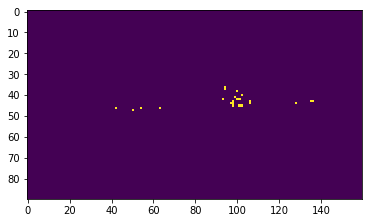

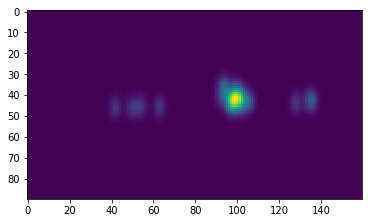

In [7]:
dataset = 3
ds, t, vlist, salmap = saleval.dat[dataset][0]
fixlist = [[t, vlist[idx], -1, -1] for idx,_ in enumerate(vlist)]
fmap = headoren.create_fixation_map(fixlist, dataset)
plt.imshow(fmap)
plt.figure()
plt.imshow(salmap)
print t, ds

0.08920620580763855 0.00027063952802410966 0.0 1.0133570250784742e-89


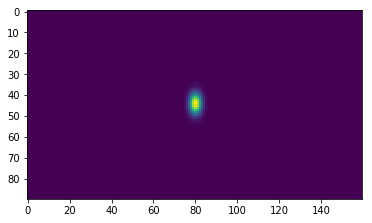

In [15]:

heat_mapi = salsal.create_saliency([fixlist[0]], dataset)
plt.imshow(heat_mapi)
heat_mapi = salsal.create_saliency([[0.0, [-1.0, 0, 0], 0, 0]], 1)
plt.imshow(heat_mapi)
print heat_mapi.max(), heat_mapi.mean(), heat_mapi.min(), np.median(heat_mapi)


In [8]:
#create individual heat map for saliency. Important
import timeit
btime = timeit.default_timer()

heat_map_list = []
for i in np.arange(len(fixlist)):
    heat_mapi = salsal.create_saliency([fixlist[i]], dataset)
    heat_map_list.append(heat_mapi)
print timeit.default_timer() - btime

#10 seconds for 1 frames, total number of evaluation: 

8.7027258873


In [16]:
def get_false_geoxy(_topic, _false_gxy_dict, topk=5):
    temp = []
    result = []
    for t in _false_gxy_dict.keys():
        if t != _topic:
            temp = temp + _false_gxy_dict[t]
    idx_list = range(len(temp))
    np.random.shuffle(idx_list)
    idx_list = idx_list[:topk]
    for idx in idx_list:
        result += temp[idx]
    return result

def sAUC_baseline(_heat_map_list, _true_fixation_list, _true_geoxy_list, _false_geoxy_dict, _vec_map, _gaussian_dict, _width, _height):
    split_n = 3
    split_pos = 0   
    
    false_geoxy_list = get_false_geoxy('2', _false_geoxy_dict, topk=5)
    

    idx_list_train, idx_list_val, fixation_train_list, fixation_val_list =\
                create_split(split_n, split_pos, _true_fixation_list)
    salient_map = sum([_heat_map_list[i] for i in idx_list_val])
    true_geoxy_list_train = [_true_geoxy_list[idx] for idx in idx_list_train]
        
    #human model
    y_pred = [salient_map[x, y] for (x, y) in true_geoxy_list_train]
    y_pred += [salient_map[x, y] for (x, y) in false_geoxy_list]
    #horizontal model
    y_pred_horizon = [1.0 - np.abs(get_fixation.geoy_to_phi(x, _height))/90.0 for (x, y) in true_geoxy_list_train]
    y_pred_horizon += [1.0 - np.abs(get_fixation.geoy_to_phi(x, _height))/90.0 for (x, y) in false_geoxy_list]
    #center model
    y_pred_center = [salient_center_map[x, y] for (x, y) in true_geoxy_list_train]
    y_pred_center += [salient_center_map[x, y] for (x, y) in false_geoxy_list]
    #true fixation
    y_true = [1 for (y, x) in true_geoxy_list_train]
    y_true += [0 for (y, x) in false_geoxy_list]

    return metrics.roc_auc_score(y_true, y_pred),\
            metrics.roc_auc_score(y_true, y_pred_horizon),\
            metrics.roc_auc_score(y_true, y_pred_center)

pacman 27.460000000000022


pacman 10.600000000000009
12
0.9857142857142857
total time taken:  1.38693213463


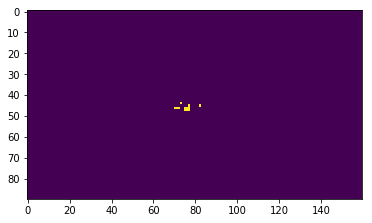

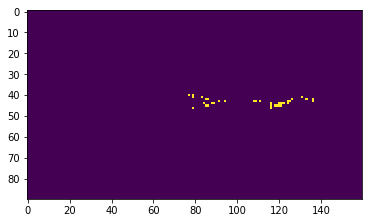

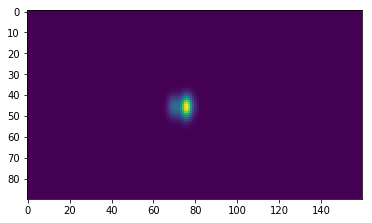

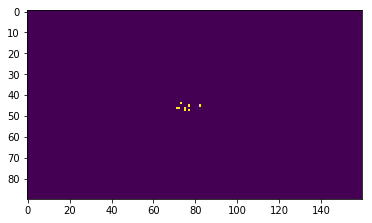

In [77]:
import timeit

btime = timeit.default_timer()

dataset = 3
idx = np.random.randint(len(saleval.dat[dataset]))
topic, t, vpos_list, salmap = saleval.dat[dataset][idx]
vneg_list = saleval.get_negative_fixations(dataset, topic)
print topic, t

#now I have positive, negative fixation, need to create saliency list
fixpos_list = [(t, v, _, _) for v in vpos_list]
fixneg_list = [(t, v, _, _) for v in vneg_list]
fposmap = headoren.create_fixation_map(fixpos_list, dataset)
fnegmap = headoren.create_fixation_map(fixneg_list, dataset)

np.random.shuffle(fixpos_list)
npos= len(fixpos_list)/3
fixposeval_list = fixpos_list[:npos]
fixpostrain_list = fixpos_list[npos:]
val_salmap = salsal.create_saliency(fixposeval_list, dataset)
train_fmap = headoren.create_fixation_map(fixpostrain_list, dataset)
geoxy_train = zip(*np.where(train_fmap==1))
geoxy_neg = zip(*np.where(fnegmap==1))

#val_salmap must be evaluated against geoxy_train + geoxy_neg

y_pred = [val_salmap[hi, wi] for (hi, wi) in geoxy_train]
y_pred += [val_salmap[hi, wi] for (hi, wi) in geoxy_neg]

y_true = [1 for item in geoxy_train]
y_true += [0 for item in geoxy_neg]

plt.imshow(fposmap)
plt.figure()
plt.imshow(fnegmap)
plt.figure()

plt.imshow(val_salmap)
plt.figure()
plt.imshow(train_fmap)

print len(fixpos_list)
print metrics.roc_auc_score(y_true, y_pred)

print 'total time taken: ', timeit.default_timer() - btime

In [71]:
baseline_circle = None
baseline_equator = [1.0 - np.abs(head_orientation_lib.geoy_to_phi(hi, head_orientation_lib.H))/90.0 for (hi, wi) in geoxy_train]

In [59]:
head_orientation_lib.H/2, head_orientation_lib.W/2

(45, 80)

In [111]:
dataset = 3
result = []
for idx, (topic, t, vpos_list, salmap) in enumerate(saleval.dat[dataset][:200]):
    if len(vpos_list) < 15:
        print 'Warning, not enough data at : {}, {}, {}, SKIPPED'.format(topic, t, len(vpos_list))
        continue
    sauc = saleval.sauc(dataset, topic, vpos_list)
    print idx, sauc, np.mean(result), topic, t, len(vpos_list)
    result.append(sauc)
result = np.array(result)
print result.mean()

0 0.9600694444444444 nan panel 27.640000000000022 23
1 0.7582417582417582 0.9600694444444444 ride 50.50000000000004 19
2 0.7972972972972973 0.8591556013431013 diving 8.260000000000007 21
3 0.731186224489796 0.8385361666611666 coaster2_ 50.08000000000004 47
4 0.5118159203980099 0.811698681118324 landscape 59.86000000000005 17
5 0.7578125 0.7517221289742612 game 5.740000000000004 36
6 1.0 0.7527371908118843 sport 28.240000000000023 20
Warning, not enough data at : panel, 31.06, 14, SKIPPED
8 1.0 0.7880604492673294 drive 40.42000000000004 27
9 0.8974603174603175 0.8145528931089132 coaster_ 44.08000000000004 37
10 0.6534598214285714 0.8237648291479581 panel 19.480000000000018 20
11 0.6870527000650618 0.8067343283760195 coaster2_ 52.96000000000004 43
12 0.8295454545454546 0.7958541803477506 coaster_ 16.900000000000013 16
13 0.8090909090909091 0.7986617865308926 diving 59.68000000000005 38
14 0.9030054644808744 0.7994640267278169 panel 49.780000000000044 17
Warning, not enough data at : game

125 0.5162579957356077 0.7917113786017412 panel 52.54000000000005 41
126 0.7016806722689075 0.7889568447730799 ride 23.56000000000002 25
127 0.6022727272727273 0.7880927242532366 landscape 33.28000000000003 30
128 0.7217365967365967 0.7862709595769573 game 34.42000000000003 32
129 0.7950872656755009 0.7856444123649148 pacman 48.94000000000004 25
130 0.4792768959435626 0.7857352090313625 diving 6.580000000000005 31
131 0.6600361663652803 0.7828165584305263 coaster2_ 34.78000000000003 31
Warning, not enough data at : pacman, 13.72, 1, SKIPPED
133 0.8370726495726497 0.781658252845005 pacman 13.24000000000001 17
134 0.809274193548387 0.7821761444032073 coaster2_ 43.78000000000004 30
135 0.8128551136363636 0.7824270522656627 landscape 11.740000000000009 24
136 0.8067226890756303 0.7827062087919994 coaster_ 13.900000000000011 25
Warning, not enough data at : pacman, 13.06, 7, SKIPPED
138 0.7317004504504504 0.7829245404309414 coaster_ 51.94000000000005 35
139 0.5715539947322212 0.782463062142

In [ ]:
saleval.dat